<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-scale-annotations" data-toc-modified-id="Load-scale-annotations-1">Load scale annotations</a></span></li></ul></div>

In [4]:
import torch
import albumentations as A
from hrnet import HRNet

import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm.auto as tqdm
import json

import os
import time
import glob

### Load scale annotations

In [5]:
annotations = {}
anno_paths = glob.glob('../scale_annotation/results/*.json')
for anno_path in anno_paths:
    with open(anno_path,'r') as f:
        annos = json.load(f)
        for anno in tqdm.tqdm(annos):
            keypoint_names = anno['params']['geometries']['point']['objects_to_annotate']
            img_name = anno['metadata']['filename']
            img_path = f'../scale_annotation/images/{img_name.split(".")[0]}/{img_name}'
            if '.top' in img_name:
                uvs = np.zeros((len(keypoint_names),2))*np.nan
                for pt in anno['response']['annotations']:
                    ix = keypoint_names.index(pt['label'])
                    uvs[ix,0] = pt['x']
                    uvs[ix,1] = pt['y']
                annotations[img_path] = uvs

100%|██████████| 3000/3000 [00:00<00:00, 270274.77it/s]


In [6]:
keypoint_names

['tail_tip',
 'tail_base',
 'spine_low',
 'spine_mid',
 'spine_high',
 'left_ear',
 'right_ear',
 'forehead',
 'nose_tip',
 'left_hind_paw_front',
 'left_hind_paw_back',
 'right_hind_paw_front',
 'right_hind_paw_back',
 'left_fore_paw',
 'right_fore_paw']

In [7]:
def rgb_to_gray(rgb_kernel):
    gray_kernel = torch.sum(rgb_kernel, dim=1, keepdim=True)
    return gray_kernel

def load_pretrained(hrnet, pretrain_dataset='imagenet'):
    pretrained_path = f'/n/groups/datta/mo/torch_keypoint_detection/pretrained_weights/{pretrain_dataset}_pretrained.pth'
    pretrained_weights = torch.load(pretrained_path)
    hrnet_weights = hrnet.state_dict()
    
    hrnet_weights['conv1.weight'] = rgb_to_gray(pretrained_weights['conv1.weight'])
    for key in hrnet_weights.keys():
        if key.startswith('conv1') or key.startswith('final'):
            continue
            
        pretrained_shape = pretrained_weights[key].shape
        hrnet_shape = hrnet_weights[key].shape
        if any([x1 != x2 for x1, x2 in zip(pretrained_shape, hrnet_shape)]):
            print('Warning', key, 'shapes do not match! Skipping.')
            continue
        
        hrnet_weights[key] = pretrained_weights[key]
        
    hrnet.load_state_dict(hrnet_weights)
    return hrnet


def crop_image(image, centroid, crop_size):
    """Crop an image around a centroid.

    Parameters
    ----------
    image: ndarray of shape (height, width, 3)
        Image to crop.

    centroid: tuple of int
        (x,y) coordinates of the centroid.

    crop_size: int or tuple(int,int)
        Size of the crop around the centroid. Either a single int for a square
        crop, or a tuple of ints (w,h) for a rectangular crop.


    Returns
    -------
    image: ndarray of shape (crop_size, crop_size, 3)
        Cropped image.
    """
    if isinstance(crop_size, tuple):
        w, h = crop_size
    else:
        w, h = crop_size, crop_size
    x, y = int(centroid[0]), int(centroid[1])

    x_min = max(0, x - w // 2)
    y_min = max(0, y - h // 2)
    x_max = min(image.shape[1], x + w // 2)
    y_max = min(image.shape[0], y + h // 2)

    cropped = image[y_min:y_max, x_min:x_max]
    padded = np.zeros((h, w, *image.shape[2:]), dtype=image.dtype)
    pad_x = max(w // 2 - x, 0)
    pad_y = max(h // 2 - y, 0)
    padded[
        pad_y : pad_y + cropped.shape[0], pad_x : pad_x + cropped.shape[1]
    ] = cropped
    return padded


In [8]:
import numpy as np
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch
from torch.utils.data import DataLoader as TorchDataLoader


def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[..., i] = a
    return arr

def get_grid(W, H, num_keypoints, downsample=4):
    grid = cartesian_product(np.arange(0, W, downsample, dtype=np.float32),
                             np.arange(0, H, downsample, dtype=np.float32))
    grid = np.repeat(grid[None], num_keypoints, axis=0)
    return grid

def uv_to_heatmap(uv, grid, sigma):
    vu = np.copy(np.flip(uv, axis=-1))
    isnan = np.isnan(vu[:, 0])
    vu[isnan] = 0
    y = np.exp(-np.sum((grid - vu[:,None,None,:]) ** 2, axis=-1) / sigma)
    y[isnan] = 0
    return y


class DataLoader(Dataset):
    def __init__(self, annotations, augment=True, crop_size=512,
                 sigma=5, stride=2):
        self.annotations = annotations
        self.image_paths = sorted(self.annotations.keys())
        self.num_keypoints = annotations[self.image_paths[0]].shape[0]
        self.crop_size = crop_size
        self.sigma = sigma

        self.grid = get_grid(
            crop_size, crop_size, 
            self.num_keypoints, 
            downsample=stride)
        
        if augment:
            self.transform = A.Compose(
                [
                    A.ShiftScaleRotate(p=0.8, scale_limit=0.2, rotate_limit=25, border_mode=1),
                    A.GaussNoise(p=0.25),
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                ], 
                keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        else:
            self.transform = None

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        keypoints = self.annotations[img_path]
        keypoints_mask = np.isnan(keypoints).any(1)
        keypoints = np.nan_to_num(keypoints)
        image = cv2.imread(img_path)
        
        s = int(np.min(image.shape[:2]))-2
        crop_center = keypoints.sum(0)/(1-keypoints_mask).sum(0)
        crop_center = (crop_center + np.random.normal(0,1,(2,))).astype(int)
        image = crop_image(image, crop_center, s)
        keypoints = keypoints - crop_center + s//2        
        
        if not self.transform is None:
            transformed = self.transform(image=image, keypoints=keypoints)
            image = transformed['image']
            keypoints = np.array(transformed['keypoints'])
            
        margin = (s - self.crop_size)//2
        image = image[margin:-margin,margin:-margin]
        keypoints = keypoints-margin

        heatmap = uv_to_heatmap(keypoints, self.grid, sigma=self.sigma) #* keypoints_mask[:,None,None]
        image = torch.tensor(image[None,:,:,0].astype(np.float32))/255
        heatmap = torch.tensor(heatmap.astype(np.float32))
        return image, heatmap

In [9]:
import glob
train_annotations = {}
test_annotations = {}

np.random.seed(0)
for k in sorted(annotations):
    if np.random.uniform() < .1:
        test_annotations[k] = annotations[k]
    else:
        train_annotations[k] = annotations[k]

In [10]:
train_loader = TorchDataLoader(DataLoader(train_annotations, sigma=100,), batch_size=8, shuffle=True)
test_loader = TorchDataLoader(DataLoader(test_annotations, sigma=100, augment=False), batch_size=8, shuffle=True)

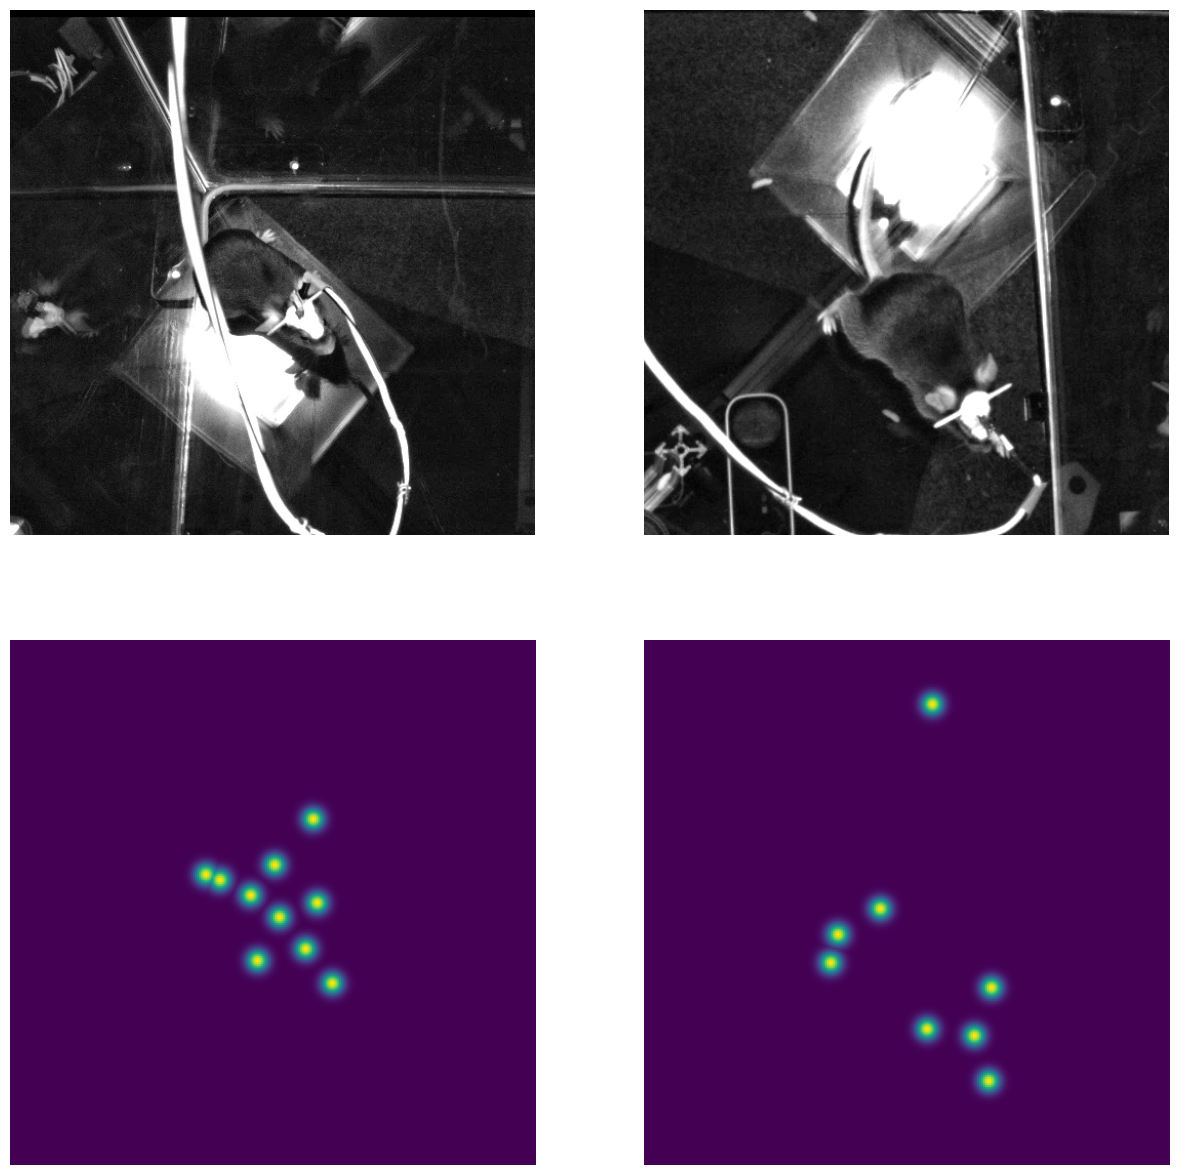

In [13]:
img,hm = next(iter(train_loader))
fig,axs = plt.subplots(2,2)
for i in range(axs.shape[1]):
    axs[0,i].imshow(img[i][0], cmap=plt.cm.gray)
    axs[1,i].imshow(hm[i].max(0)[0])
for ax in axs.flat: ax.axis('off')
fig.set_size_inches((15,15))

In [14]:
pretrain_dataset = 'imagenet'
batch_size = 8
learning_rate = 1e-3
num_epochs = 250

model = HRNet(nof_joints=train_loader.dataset.num_keypoints)
model = model.to('cuda')

In [9]:
assert pretrain_dataset in ['imagenet', 'mpii']
checkpoint_dir = 'hrnet_top_checkpoints'
if not os.path.exists(checkpoint_dir) or len(os.listdir(checkpoint_dir))==0:
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0
    model = load_pretrained(model, pretrain_dataset)
else:
    file_names = os.listdir(checkpoint_dir)
    max_epoch = 30 #max([int(f[len(pretrain_dataset) + 1: -4]) for f in file_names])
    start_path = os.path.join(checkpoint_dir, f'{pretrain_dataset}_{max_epoch}.pth')
    start_epoch = max_epoch + 1
    pretrained_weights = torch.load(start_path)
    model.load_state_dict(pretrained_weights)


In [10]:
model = model.to('cuda')
mse = torch.nn.MSELoss()
history = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/4)
model = model.eval()
for epoch in range(start_epoch, num_epochs):
    train_losses = []
    for x, y in tqdm.tqdm(train_loader):
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x)
        loss = mse(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        del x, y, y_pred

    # save at the end of each epoch
    save_path = os.path.join(checkpoint_dir, f'{pretrain_dataset}_{epoch}.pth')
    torch.save(model.state_dict(), save_path)
    
    test_losses = []
    for x, y in tqdm.tqdm(test_loader):
        with torch.no_grad():
            x = x.to('cuda')
            y = y.to('cuda')  
            y_pred = model(x)
            test_losses.append(mse(y_pred, y).item())
            del x, y, y_pred
            
    print(epoch, np.mean(train_losses), np.mean(test_losses))
    history.append((epoch, np.mean(train_losses), np.mean(test_losses)))


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


31 0.00017704733123067735 0.0001789051944797393


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


32 0.00015821653861528692 0.00018596932641230525


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


33 0.00015530306156643327 0.00017862790991785005


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


34 0.00015569922126365215 0.00017756068627932108


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


35 0.00015044455702531762 0.0001743297551001888


100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


36 0.00014697551570509772 0.00017844226385932416


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


37 0.0001487883526214739 0.00017856362319434993


 40%|███▉      | 74/186 [02:00<03:02,  1.63s/it]


KeyboardInterrupt: 

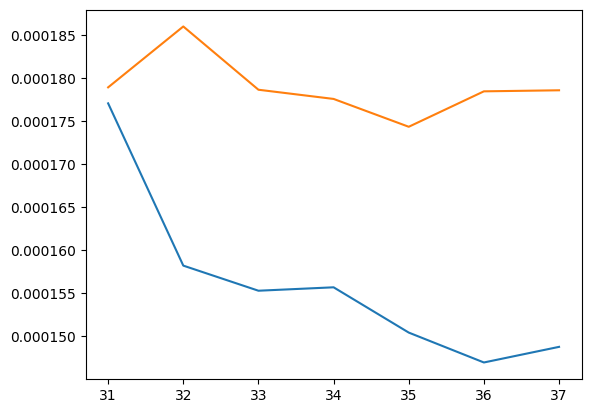

In [12]:
h = np.array(history)
plt.plot(h[:,0],h[:,1])
plt.plot(h[:,0],h[:,2])

In [15]:
pretrained_weights = torch.load('weights/hrnet_top.pth')
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

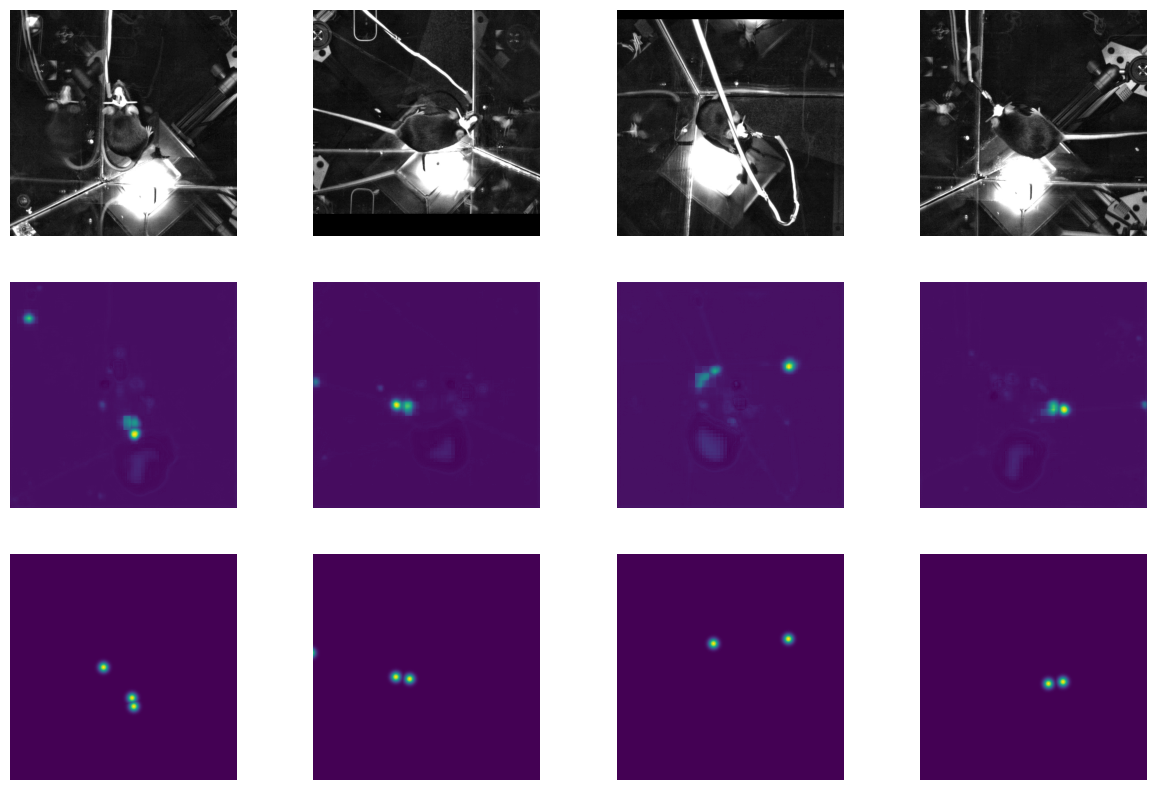

In [19]:
img,hm = next(iter(test_loader))
y = model(img.to('cuda')).detach().cpu().numpy()
img = img.numpy()
hm = hm.numpy()
fig,axs = plt.subplots(3,4)
for i in range(axs.shape[1]):
    axs[0,i].imshow(img[i][0], cmap=plt.cm.gray)
    axs[1,i].imshow(y[i][:3].max(0))
    axs[2,i].imshow(hm[i][:3].max(0))
for ax in axs.flat: ax.axis('off')
fig.set_size_inches((15,10))

In [18]:
from vidio.read import OpenCVReader
reader = OpenCVReader('../data/20230815_gmou97/side1.24548223.avi')

In [20]:
im = reader[1000]
y_pred = model(torch.tensor(im.astype(np.float32)[None,None,:,:,0]).to('cuda')/255)

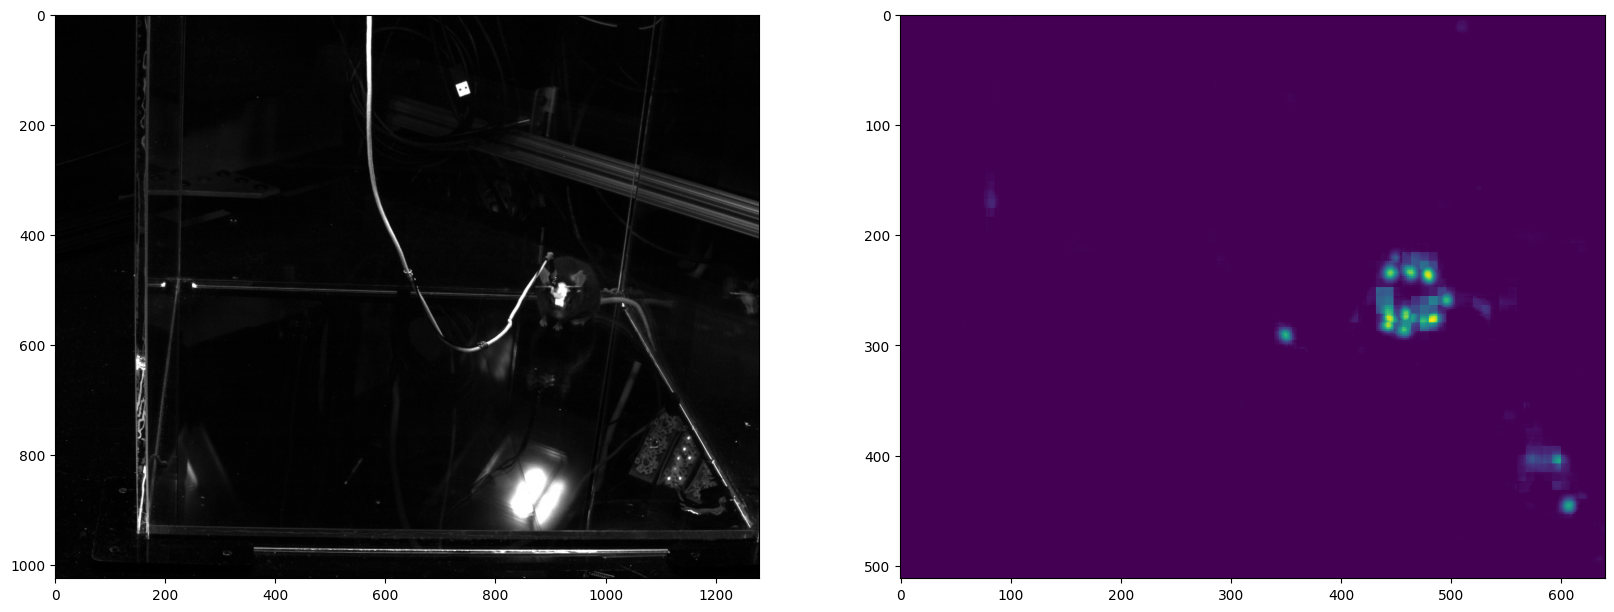

In [21]:
fig,axs = plt.subplots(1,2)
axs[0].imshow(im)
axs[1].imshow(y_pred.detach().cpu().numpy()[0].max(0))
fig.set_size_inches((20,10))